<a href="https://colab.research.google.com/github/mariaoliv/malaria_detection_pt/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json (you should manually select this file when prompted)
uploaded = files.upload()

# Make sure the file exists
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#! kaggle competitions download -c 'name-of-competition'
!kaggle datasets download -d rajsahu2004/lacuna-malaria-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/rajsahu2004/lacuna-malaria-detection-dataset
License(s): CC0-1.0
100% 3.98G/3.99G [00:44<00:00, 57.5MB/s]
100% 3.99G/3.99G [00:44<00:00, 97.0MB/s]


In [ ]:
import zipfile
import os

# Path to your zip file (update this if needed)
zip_file_path = '/content/lacuna-malaria-detection-dataset.zip'

# Directory where you want to extract the files
extract_dir = '/content/extracted_data/'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted directory to confirm
os.listdir(extract_dir)

['Train.csv', 'images', 'SampleSubmission.csv', 'Test.csv']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.random.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('/content/extracted_data/Train.csv')
print(df['class'].unique())
df.head()

['Trophozoite' 'NEG' 'WBC']


,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0


In [ ]:
print(df['class'].value_counts())

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['class'])

In [ ]:
print(len(df))

23530


In [ ]:
import torchvision

img = torchvision.io.read_image(os.path.join('/content/extracted_data/images', df.iloc[0]["Image_ID"]))
print(type(img))
print(img.dtype)
img.shape

<class 'torch.Tensor'>
torch.uint8


torch.Size([3, 1080, 1920])

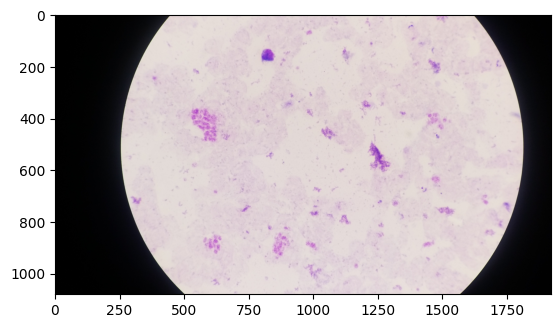

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))

In [ ]:
from torch.utils.data import Dataset, dataloader
from torchvision.transforms import v2

In [ ]:
transforms = v2.Compose([
    v2.Resize((128, 128)),
    v2.ConvertImageDtype(torch.float32),
    v2.Normalize(mean=[0,0,0], std=[1,1,1]),
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomGrayscale(p=0.1),
    v2.RandomInvert(p=0.05)
])

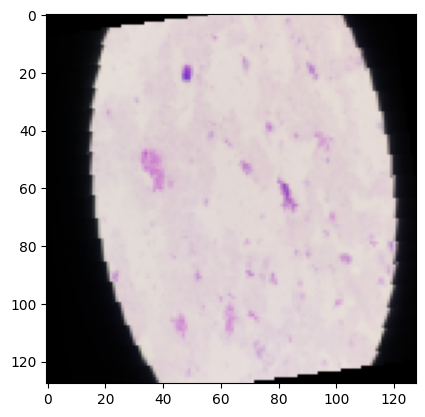

In [ ]:
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [ ]:
class LACUNADataset(Dataset):
  def __init__(self, df, root_dir='/content/extracted_data/images', transform=None):
    self.df = df
    self.root_dir = root_dir
    self.transform = transform
    self.classes = {'NEG': 0, 'Trophozoite': 1, 'WBC': 2}

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = os.path.join(self.root_dir, row['Image_ID'])
    img = torchvision.io.read_image(img_path)
    if self.transform:
      img = self.transform(img)
    label = torch.tensor(self.classes[row['class']])

    return {'image' : img, 'label' : label}

In [ ]:
lacuna_dataset = LACUNADataset(df, transform=transforms)
lacuna_dataset[0]

{'image': tensor([[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.00

In [ ]:
train_dataset = LACUNADataset(train_df, transform=transforms)
val_dataset = LACUNADataset(val_df, transform=transforms)
test_dataset = LACUNADataset(test_df, transform=transforms)

In [ ]:
generator = torch.Generator(device='cpu')
generator.manual_seed(42)
train_dataloader = dataloader.DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator, num_workers=4)
val_dataloader = dataloader.DataLoader(val_dataset, batch_size=32, shuffle=True, generator=generator, num_workers=4)
test_dataloader = dataloader.DataLoader(test_dataset, batch_size=32, shuffle=True, generator=generator, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LACUNAModel(nn.Module):
  def __init__(self):
    super().__init__()


    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5) #12, 124, 124
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5) #12, 120, 120
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 12, 60, 60
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=6)

    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.softmax = nn.Softmax(dim=1)

    self.fc1 = nn.Linear(in_features=24*12*12, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=3)


  def forward(self, x, apply_softmax=False):
    out = self.relu(self.conv1(x)) #12, 124, 124
    out = self.relu(self.conv2(out)) #12, 120, 120
    out = self.pool(out) #12, 60, 60
    out = self.relu(self.conv3(out)) #24, 58, 58
    out = self.pool(out) #24, 29, 29
    out = self.relu(self.conv4(out)) #24, 24, 24
    out = self.pool(out) #24, 12, 12
    out = self.flatten(out)

    out = self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(out))))))

    if apply_softmax:
      out = self.softmax(out)

    return out


In [ ]:
x = train_dataset[0]['image']
LACUNAModel()(x.unsqueeze(0))

tensor([[0.0285, 0.0049, 0.0000]], grad_fn=<ReluBackward0>)

In [ ]:
x = next(iter(train_dataloader))
LACUNAModel()(x['image'])

tensor([[0.0421, 0.0120, 0.0255],
        [0.0424, 0.0115, 0.0255],
        [0.0417, 0.0114, 0.0261],
        [0.0419, 0.0112, 0.0255],
        [0.0401, 0.0116, 0.0267],
        [0.0413, 0.0110, 0.0259],
        [0.0424, 0.0109, 0.0253],
        [0.0422, 0.0112, 0.0254],
        [0.0416, 0.0114, 0.0263],
        [0.0425, 0.0113, 0.0257],
        [0.0415, 0.0112, 0.0258],
        [0.0422, 0.0111, 0.0254],
        [0.0413, 0.0110, 0.0258],
        [0.0421, 0.0112, 0.0256],
        [0.0424, 0.0111, 0.0251],
        [0.0421, 0.0114, 0.0252],
        [0.0421, 0.0109, 0.0255],
        [0.0423, 0.0115, 0.0258],
        [0.0415, 0.0107, 0.0259],
        [0.0421, 0.0116, 0.0258],
        [0.0426, 0.0112, 0.0259],
        [0.0422, 0.0110, 0.0255],
        [0.0420, 0.0117, 0.0256],
        [0.0420, 0.0111, 0.0254],
        [0.0418, 0.0109, 0.0256],
        [0.0414, 0.0116, 0.0252],
        [0.0419, 0.0112, 0.0254],
        [0.0417, 0.0110, 0.0256],
        [0.0412, 0.0110, 0.0261],
        [0.041

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

model = LACUNAModel()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = CrossEntropyLoss()
num_epochs = 10

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs):
  model.train()
  #train_loss = 0
  for i in range(num_epochs):
    train_loss = 0
    for batch in tqdm(train_dataloader):
      x = batch['image'].to(device)
      y = batch['label'].to(device)
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    val_loss, val_accuracy = test(model, val_dataloader, loss_fn, device)
    print(f"Epoch: {i+1}, Train Loss: {train_loss/len(train_dataloader)}, Val Loss: {val_loss/len(val_dataloader)}, Val Accuracy: {val_accuracy/len(val_dataloader)}")


#for test and val sets
def test(model, test_dataloader, loss_fn, device):
  model.eval()
  test_loss = 0
  accuracy = 0
  with torch.no_grad():
    for batch in tqdm(test_dataloader):
      x = batch['image'].to(device)
      y = batch['label'].to(device)
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      accuracy += (y_pred.argmax(dim=1) == y).sum().item()
  return test_loss, accuracy


In [ ]:
train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.0986212091251626, Val Loss: 1.0986120700836182, Val Accuracy: 0.918918918918919


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.0986120704884035, Val Loss: 1.0986120700836182, Val Accuracy: 0.918918918918919


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.0986120704884035, Val Loss: 1.0986120700836182, Val Accuracy: 0.918918918918919


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.0986120704884035, Val Loss: 1.0986120700836182, Val Accuracy: 0.918918918918919


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.0986120704884035, Val Loss: 1.0986120700836182, Val Accuracy: 0.918918918918919


  0%|          | 0/589 [00:00<?, ?it/s]